Scale pos weight = 1.00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🟢 Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.65      0.98      0.79      3863
         1.0       0.97      0.49      0.65      3957

    accuracy                           0.73      7820
   macro avg       0.81      0.74      0.72      7820
weighted avg       0.81      0.73      0.72      7820


🟠 Matrice de confusion :
[[3800   63]
 [2016 1941]]

🔵 Accuracy : 0.7341


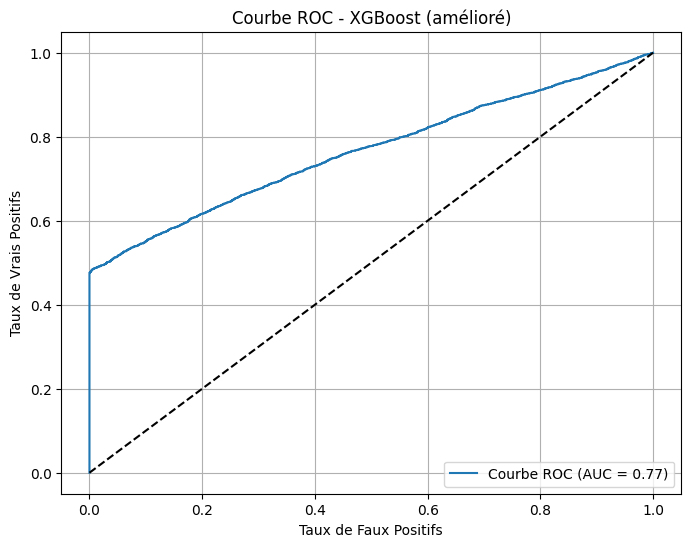

<Figure size 1000x800 with 0 Axes>

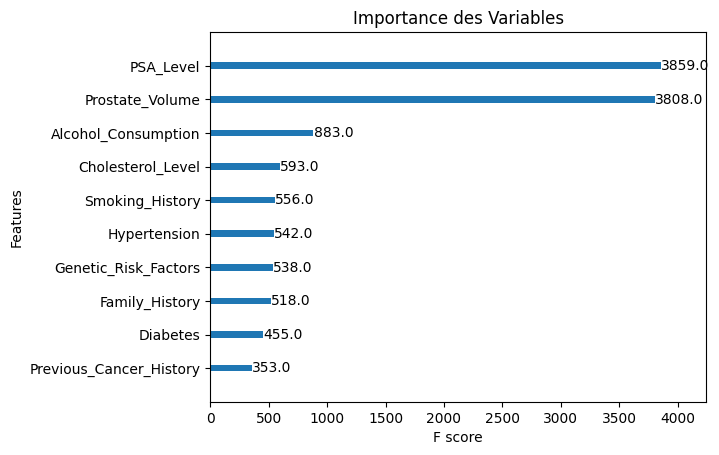

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


🔁 Validation croisée (5-folds) - Accuracy moyenne : 0.7353
✅ Modèle amélioré sauvegardé sous 'prostate_model.pkl'


In [25]:
# 1. Installer les bibliothèques si besoin
# !pip install pandas scikit-learn xgboost imbalanced-learn matplotlib

# 2. Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
import joblib

# 3. Charger les données
df = pd.read_csv('/content/prostate_cancer_prediction.csv')

# 4. Supprimer les colonnes inutiles
columns_to_drop = ['Patient_ID', 'Treatment_Recommended', 'BMI']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# 5. Encoder les variables catégorielles
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# 6. Imputation des valeurs manquantes
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 7. Variables sélectionnées
features_to_keep = [
    'PSA_Level',
    'Prostate_Volume',
    'Alcohol_Consumption',
    'Smoking_History',
    'Cholesterol_Level',
    'Hypertension',
    'Diabetes',
    'Genetic_Risk_Factors',
    'Previous_Cancer_History',
    'Family_History'
]

X = df[features_to_keep]
y = df['Biopsy_Result']

# 8. Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 9. Calculer scale_pos_weight
count_0 = (y_resampled == 0).sum()
count_1 = (y_resampled == 1).sum()
scale_pos_weight = count_0 / count_1
print(f"Scale pos weight = {scale_pos_weight:.2f}")

# 10. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 11. Entraînement modèle XGBoost amélioré
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.05,  # Plus petit pour mieux apprendre
    max_depth=6,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# 12. Évaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n🟢 Rapport de classification :")
print(classification_report(y_test, y_pred))
print("\n🟠 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\n🔵 Accuracy :", round(accuracy_score(y_test, y_pred), 4))

# 13. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - XGBoost (amélioré)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 14. Importance des variables
plt.figure(figsize=(10,8))
plot_importance(model, max_num_features=10)
plt.title('Importance des Variables')
plt.grid()
plt.show()

# 15. Validation croisée pour voir la stabilité
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("\n🔁 Validation croisée (5-folds) - Accuracy moyenne :", round(np.mean(cv_scores), 4))

# 16. Sauvegarde du modèle
joblib.dump(model, 'prostate_model.pkl')
print("✅ Modèle amélioré sauvegardé sous 'prostate_model.pkl'")


In [ ]:
joblib.dump(model, 'prostate_model.pkl')


['prostate_model.pkl']